<a href="https://colab.research.google.com/github/nikhanal/segmentation_with_sam2/blob/main/segment_video.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
using_colab = True

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

    !wget https://drive.google.com/uc?export=download&id=1Ksd-WUnY8P5iGwuinzQ0KvVhietW0td8

    !mkdir -p ../checkpoints/
    !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

PyTorch version: 2.5.0+cu121
Torchvision version: 0.20.0+cu121
CUDA is available: True
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-bm63cmrf
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-bm63cmrf
  Resolved https://github.com/facebookresearch/sam2.git to commit c2ec8e14a185632b0a5d8b161928ceb50197eddc
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.0 MB/s eta 0:00:00
  Created wheel for SAM-2: filename=SAM_2-1.0-cp310-c

In [3]:
!pip install gdown
!gdown https://drive.google.com/uc?id=1Ksd-WUnY8P5iGwuinzQ0KvVhietW0td8


Downloading...
From: https://drive.google.com/uc?id=1Ksd-WUnY8P5iGwuinzQ0KvVhietW0td8
To: /content/exa1.mp4
100% 6.59M/6.59M [00:00<00:00, 14.6MB/s]


In [ ]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [ ]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

/usr/local/lib/python3.10/dist-packages/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [ ]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=100):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='.', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='.', s=marker_size, edgecolor='white', linewidth=1.25)

In [ ]:
import subprocess
import re

input_video = 'exa1.mp4'
output_dir = 'frames'
!mkdir -p {output_dir}


subprocess.run([
    'ffmpeg', '-i', input_video, '-q:v', '2', '-start_number', '0', f'{output_dir}/%05d.jpg'
])


result = subprocess.run(['ffmpeg', '-i', input_video], stderr=subprocess.PIPE, stdout=subprocess.PIPE)
output = result.stderr.decode('utf-8')
frame_rate_match = re.search(r'(\d+(?:\.\d+)?) fps', output)
frame_rate = float(frame_rate_match.group(1)) if frame_rate_match else 30



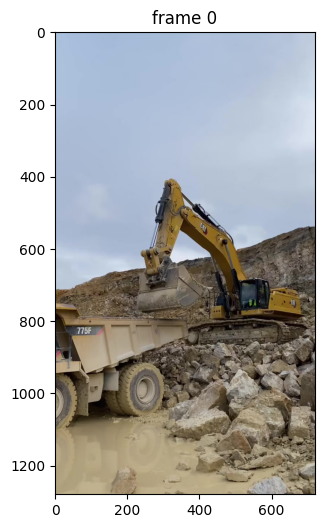

In [ ]:
video_dir = "frames"
frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))
frame_idx = 0
plt.figure(figsize=(9, 6))
plt.title(f"frame {frame_idx}")
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))

In [ ]:

# similar to set_image in image model here is init_state that store the state of video
inference_state = predictor.init_state(video_path=video_dir)
predictor.reset_state(inference_state)

frame loading (JPEG): 100%|██████████| 845/845 [00:43<00:00, 19.50it/s]


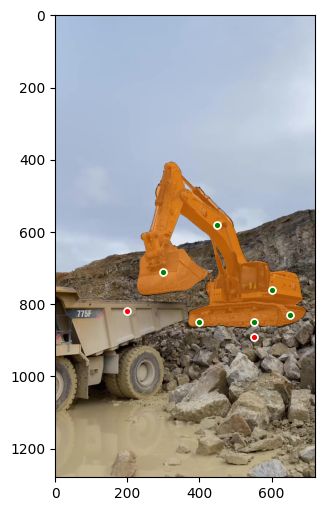

In [ ]:
frame_idx = 0
obj_id = 1

# out_obj_ids is the obect index to be masked, out_mask_logits provides the mask region
points = np.array([[300,710], [450,580],[600,760],[650,830],[400,850],[550,850],[200,820],[550,890]], dtype=np.float32)
labels = np.array([1,1,1,1,1,1,0,0], np.int32)
_, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
    inference_state=inference_state,
    frame_idx=frame_idx,
    obj_id=obj_id,
    points=points,
    labels=labels,
)


plt.figure(figsize=(9, 6))
plt.imshow(Image.open(os.path.join(video_dir, frame_names[frame_idx])))
show_points(points, labels, plt.gca())
show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])


In [ ]:
video_segments = {}
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
    video_segments[out_frame_idx] = {
        out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
        for i, out_obj_id in enumerate(out_obj_ids)
    }

propagate in video:  13%|█▎        | 114/845 [02:08<14:02,  1.15s/it]

In [ ]:
import imageio
temp_dir = "temp_frames"
os.makedirs(temp_dir, exist_ok=True)


for out_frame_idx in range(len(frame_names)):
    frame_path = os.path.join(video_dir, frame_names[out_frame_idx])
    frame = Image.open(frame_path)
    plt.figure(figsize=(6, 4))
    plt.imshow(frame)

    for out_obj_id, out_mask in video_segments.get(out_frame_idx, {}).items():
        show_mask(out_mask, plt.gca(), obj_id=out_obj_id)

    temp_frame_path = os.path.join(temp_dir, f"{out_frame_idx:05d}.png")
    plt.axis('off')
    plt.tight_layout()
    plt.savefig(temp_frame_path, bbox_inches='tight', pad_inches=0)
    plt.close()

    print(f"Saved frame {out_frame_idx} to {temp_frame_path}")


output_video = 'masked_video.mp4'


ffmpeg_command = [
    'ffmpeg', '-framerate', str(frame_rate), '-i', f'{temp_dir}/%05d.png',
    '-c:v', 'libx264', '-pix_fmt', 'yuv420p', output_video
]
subprocess.run(ffmpeg_command)

print(f"Masked video saved as {output_video}")


import shutil
shutil.rmtree(temp_dir)
print(f"Masked video saved as {output_video}")